In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import mne
import numpy as np
import json
from src.models.utils import load_dataset

# plot options
plt.rc('font', size=12) #controls default text size
plt.rc('axes', titlesize=18) #fontsize of the title
plt.rc('axes', labelsize=15) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend

# open config file
f = open("..//config//config.json",)
config = json.load(f)

In [2]:
# info object
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
info = mne.create_info(channels, config["dataset"]["sampling_frequency"], ch_types='eeg').set_montage('biosemi64')

In [3]:
# load model
model_path = "..//models//" + config["train"]["experiment_desc"] + "-best.h5"
model = tf.keras.models.load_model(model_path)

### Temporal filters

EEGNet has F1 temporal filters in the first convolutional layer. For the standard EEGNet structure, the number of temporal filters is 8.
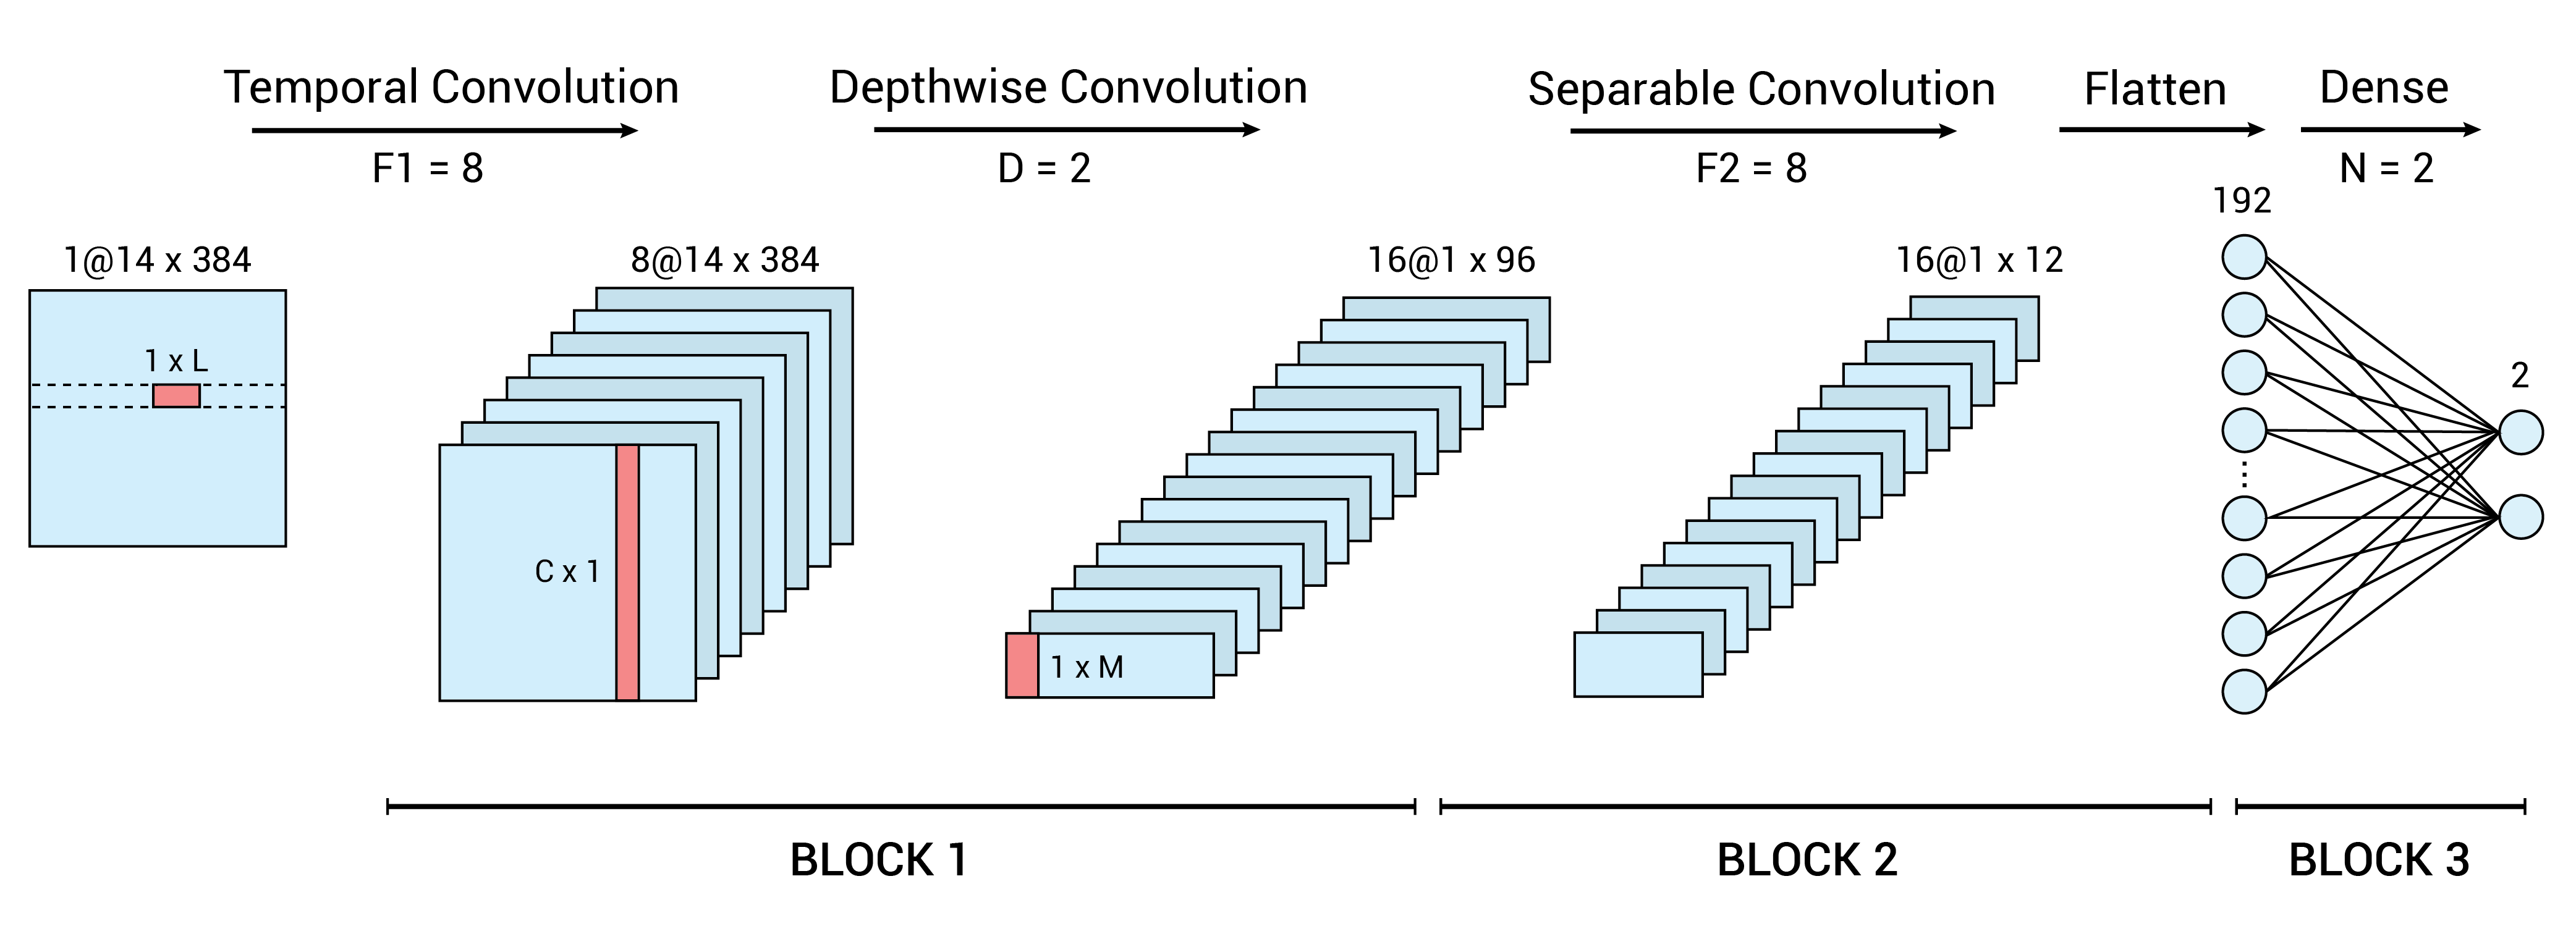

In [4]:
# get temporal filters of the 1st convolutional layer
temporal_filters_1st_layer = model.layers[1].get_weights()[0]

print(f'1st layer filters shape: {temporal_filters_1st_layer.shape}')
# 1x64 kernel x 1 x F1 temporal filters

1st layer filters shape: (1, 64, 1, 8)


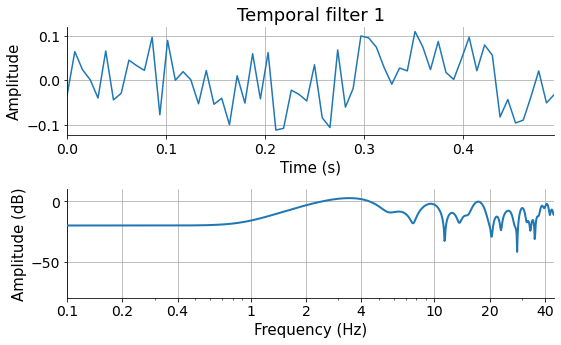

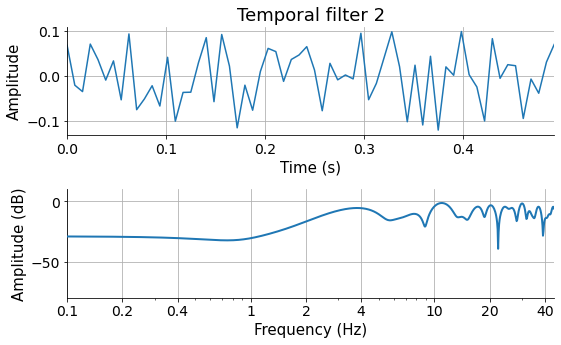

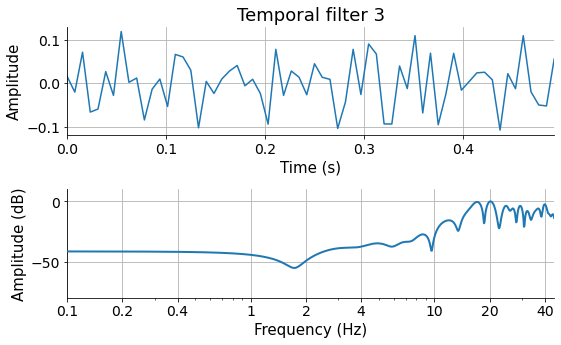

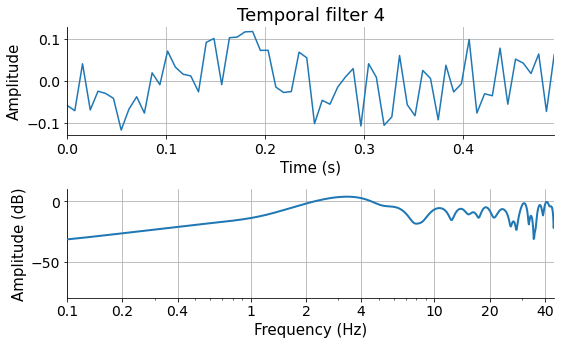

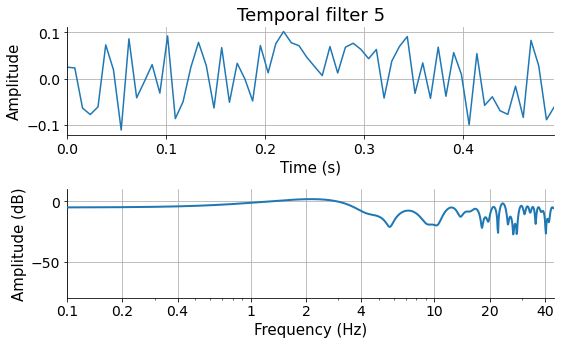

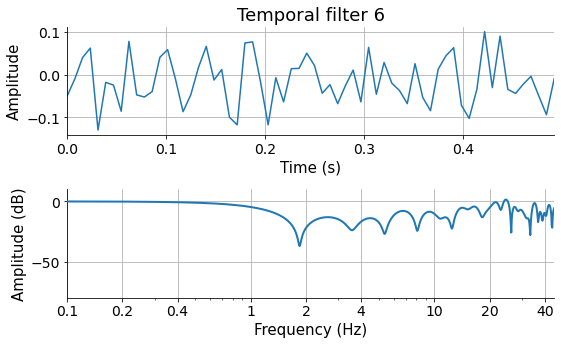

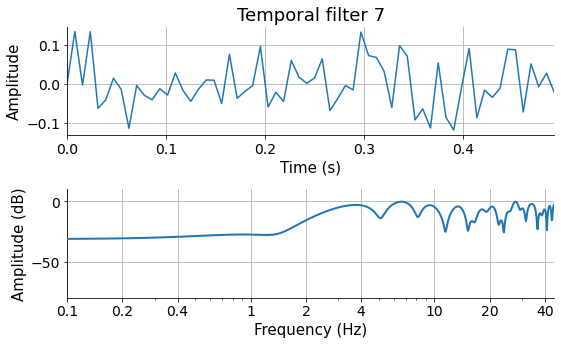

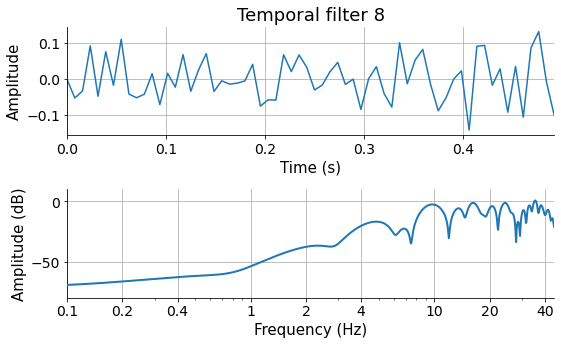

In [13]:
# plot
for n in range(temporal_filters_1st_layer.shape[3]):
    h = temporal_filters_1st_layer[:,:,:,n].squeeze()
    fig, axes = plt.subplots(figsize=(8,5), nrows=2, ncols=1)
    
    title = 'Temporal filter ' + str(n+1)
    
    fig = mne.viz.plot_filter(h, config["dataset"]["sampling_frequency"], title=title, flim=(.1,45), fscale='log', alim=(- 80, 10), show=True, compensate=False, plot=('time', 'magnitude'), axes=axes)
    
    # save figures
    fig.savefig('..//reports//filters//' + config["train"]["experiment_desc"] + '_tempfilt' + str(n+1) + '.png', bbox_inches="tight", dpi=300)
    
    # save weights
    file = config["train"]["experiment_desc"] + "_tempfilter" + str(n+1) + ".csv"
    np.savetxt("..//" + config["train"]["weights_save_path"] + file, temporal_filters_1st_layer[:,:,0,n], delimiter=",")

### Spatial filters

In EEGNet the number of spatial filters is controlled by the depth parameter D. The depth-wise convolution filters each feature map (F1) of the previous layer with D spatial filters. The output of the depth-wise convolution is thus F1*D feature maps.

In [8]:
# get spatial filters of 2nd convolutional layer (depthwiseconv)
spatial_filters_3rd_layer = model.layers[3].get_weights()[0]

print(f'3rd layer filters shape: {spatial_filters_3rd_layer.shape}')

# 14 (channels) x 1 filters. D filters for each F1 temporal filter of the previous conv layer

3rd layer filters shape: (14, 1, 8, 2)


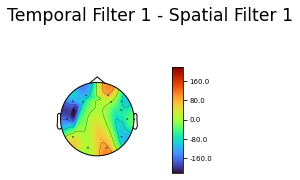

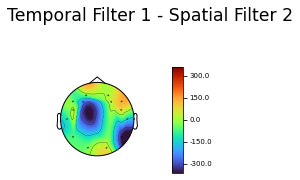

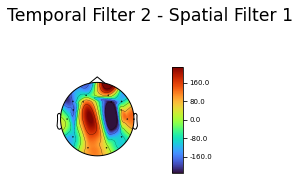

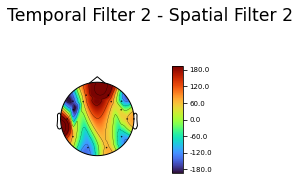

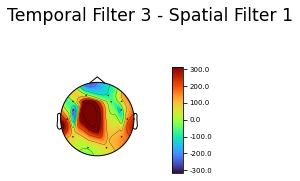

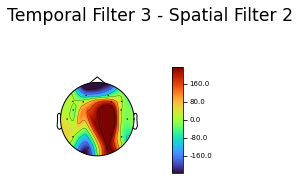

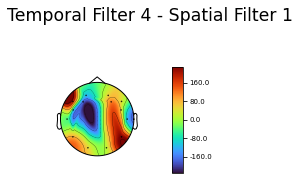

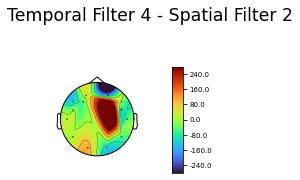

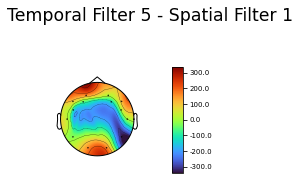

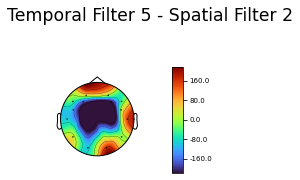

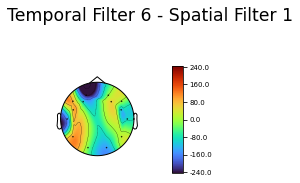

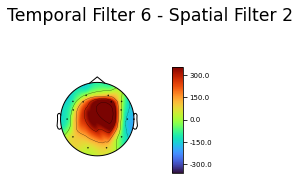

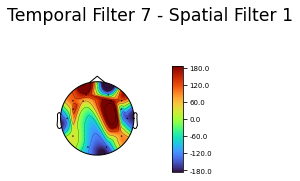

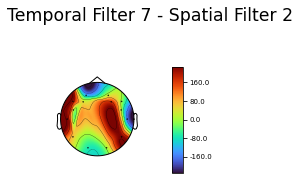

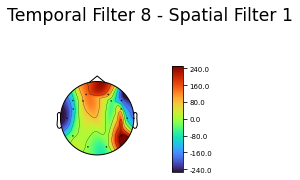

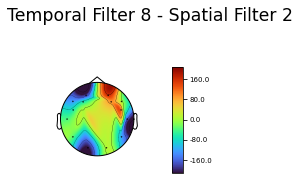

In [14]:
# plot topomaps of spatial filters

for temp in range(spatial_filters_3rd_layer.shape[2]):
    
    for spat in range(spatial_filters_3rd_layer.shape[3]):
        
        x = spatial_filters_3rd_layer[:, :, temp, spat]
        
        filt = mne.EpochsArray(x.reshape((1,14,1)), info, verbose =0)
        evok = filt.average()
        
        title = 'Temporal Filter ' + str(temp+1) + ' - Spatial Filter ' + str(spat+1)
        
        fig = evok.plot_topomap(times=0, cmap = 'turbo', units = dict(eeg = ''), title = title, colorbar = True, scalings=1e3, time_format="")
        
        # save figures
        fig.savefig('..//reports//filters//' + config["train"]["experiment_desc"] + '_tempfilt' + str(temp+1) + '_spatfilt' + str(spat+1) + '.png', dpi = 300, bbox_inches='tight')
        
        # save weights
        file = config["train"]["experiment_desc"] + "_tempfilt" + str(temp+1) + "_spatfilter" + str(spat+1) + ".csv"
        np.savetxt("..//" + config["train"]["weights_save_path"] + file, spatial_filters_3rd_layer[:,:,temp,spat], delimiter=",")

### First layer output Power Spectral Density (PSD)

By using the test data, we can get the output of the trained model at any level. The output of the first layer shows how the signal is filtered in time by the F1 temporal filters. By analyzing its PSD, the filtered-out frequencies can be seen.

In [15]:
# load test data
config["dataset"]["save_path"] = "..//data//"
_, _, _, _, X_test, y_test = load_dataset(config)

In [16]:
X_test.shape

(2330, 14, 384, 1)

In [17]:
mod = tf.keras.Model(model.layers[0].input, model.layers[1].output) # reconstruct model to give output at 1st convolutional layer
out = mod.predict(X_test)[0]
print(f'1st convolutional layer output shape: {out.shape}')

1st convolutional layer output shape: (14, 384, 8)


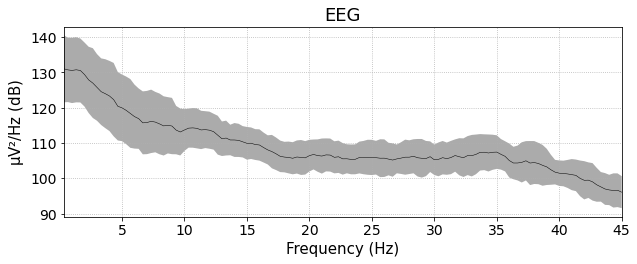

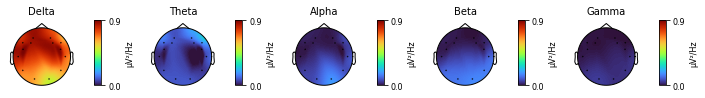

In [18]:
# INPUT
# time frequency analysis using mne
sgn = X_test[0].squeeze()
sgn = np.expand_dims(sgn,0)
input_epochs = mne.EpochsArray(sgn, info, verbose = 0)

# plot PSD and topomap of input test signal
fig1 = input_epochs.plot_psd(average=True, fmin=.1, fmax = 45, verbose=0)
bands = [(.1, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'),
         (12, 30, 'Beta'), (30, 45, 'Gamma')]

fig2 = input_epochs.plot_psd_topomap(normalize=True, cmap='turbo', vlim='joint', verbose=0, bands=bands)
# input_epochs.plot_sensors(show_names=True)

# fig1.savefig('..//reports//filters//psd_input.png',dpi=300, bbox_inches='tight')
# fig2.savefig('..//reports//filters//topomap_input.png',dpi=300, bbox_inches='tight')

First layer output of temporal filter 1


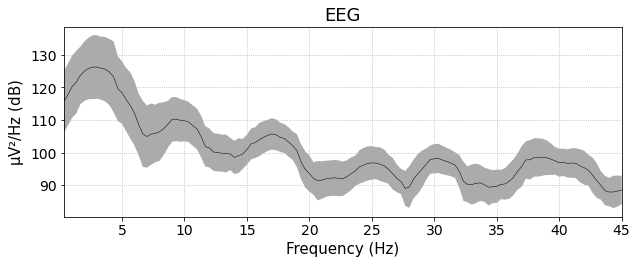

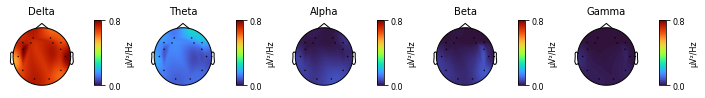

First layer output of temporal filter 2


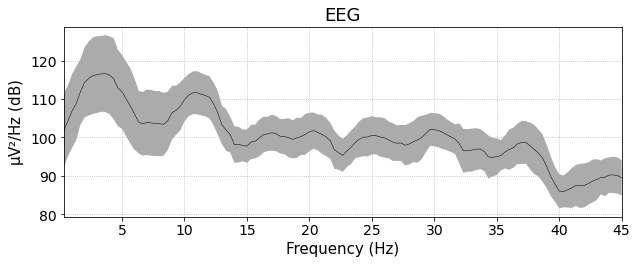

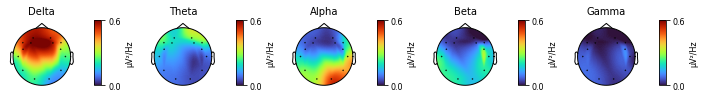

First layer output of temporal filter 3


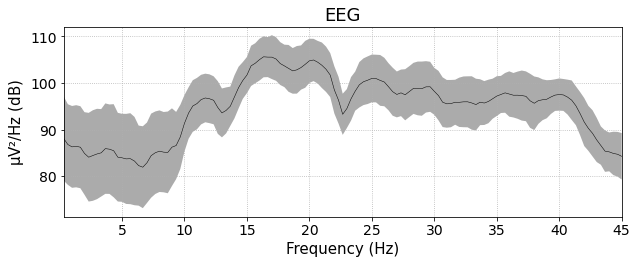

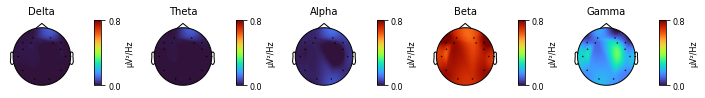

First layer output of temporal filter 4


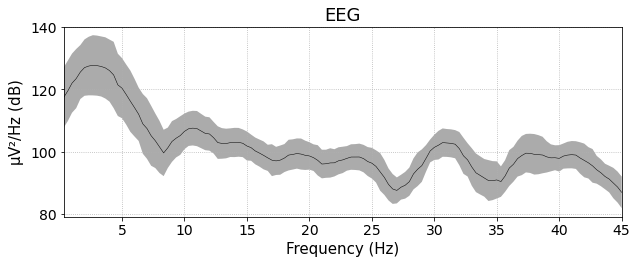

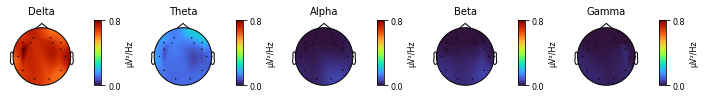

First layer output of temporal filter 5


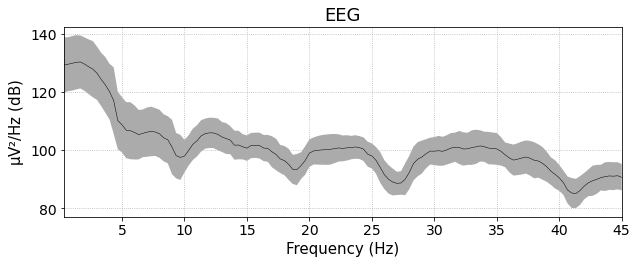

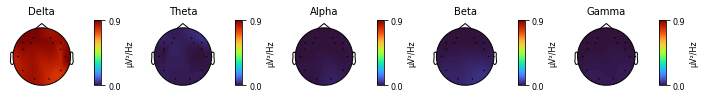

First layer output of temporal filter 6


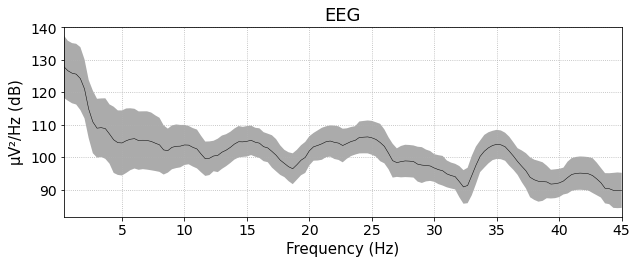

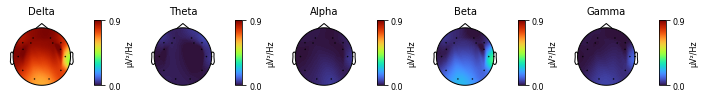

First layer output of temporal filter 7


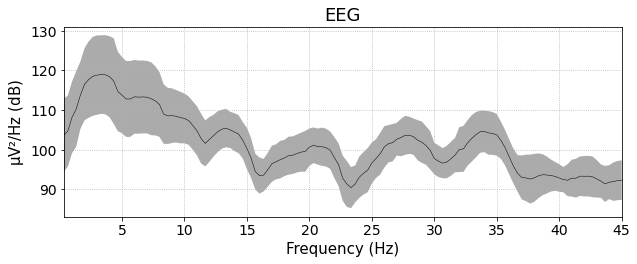

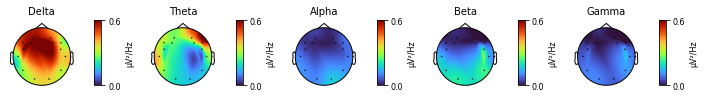

First layer output of temporal filter 8


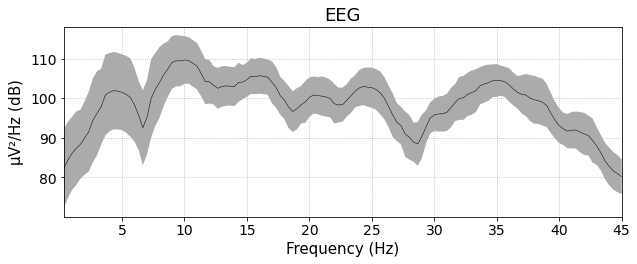

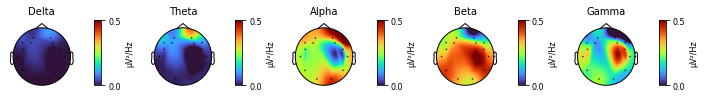

In [19]:
for fm in range(temporal_filters_1st_layer.shape[3]):
    print(f'First layer output of temporal filter {fm+1}')
    output_1stlay = mne.EpochsArray(out[:,:,fm].reshape(1,14,384), info, verbose = 0)
    fig1 = output_1stlay.plot_psd(average=True, fmin=.1, fmax = 45,verbose=0)
    fig2 = output_1stlay.plot_psd_topomap(normalize=True, cmap='turbo', vlim='joint', verbose=0,bands=bands)

    # fig1.savefig('..//reports//filters//psd_output_1stlayer.png',dpi=300, bbox_inches='tight')
    # fig2.savefig('..//reports//filters//topomap_output_1stlayer.png',dpi=300, bbox_inches='tight')